# Quadratic Edge Element for Maxwell Equations in 3D

This example is to show the quadratic edge element approximation of the electric field of the time harmonic Maxwell equation.

\begin{align}
\nabla \times (\mu^{-1}\nabla \times  u) - \omega^2 \varepsilon \, u &= J  \quad  \text{ in } \quad \Omega,  \\
                                  n \times u &= n \times g_D  \quad  \text{ on } \quad \Gamma_D,\\
                    n \times (\mu^{-1}\nabla \times  u) &= n \times g_N  \quad  \text{ on } \quad \Gamma_N.
\end{align}


based on the weak formulation

$$(\mu^{-1}\nabla \times  u, \nabla \times  v) - (\omega^2\varepsilon u,v) = (J,v) - \langle n \times g_N,v \rangle_{\Gamma_N}.$$

**Reference**
- [Finite Element Methods for Maxwell Equations](http://www.math.uci.edu/~chenlong/226/FEMMaxwell.pdf)
- [Programming of Finite Element Methods for Maxwell Equations](http://www.math.uci.edu/~chenlong/226/codeMaxwell.pdf)

**Subroutines**:

    - Maxwell2
    - cubeMaxwell2
    - femMaxwell3
    - Maxwell2femrate
    
The method is implemented in `Maxwell2` subroutine and tested in `cubeMaxwell2`. Together with other elements (ND0,ND1,ND2), `femMaxwell3` provides a concise interface to solve Maxwell equation. The ND1 element is tested in `Maxwell2femrate`. This doc is based on `Maxwell2femrate`.    

## Data Structure

Locally we construct `locBasesIdx` to record the local index used in the bases. Globally we use ascend ordering for each element and thus the orientation of the edge is consistent. No need of `elem2edgeSign`. Read [Simplicial complex in three dimensions](../mesh/sc3doc.html) for more discussion of indexing, ordering and orientation.

In addition to the edge structure, we need face and the corresponding pointers.

In [3]:
[node,elem] = cubemesh([0,1,0,1,0,1],1);
[elem2edge,edge] = dof3edge(elem);
[elem2face,face] = dof3face(elem); 

Furthermore we need pointer from face to edge. `face` is given by `auxtructure3` and is sorted according to global indices.
`face2edge` is used to compute `uI`. So it is consistent with the local index system in `edgeinterpolate2`, i.e., if face is `(i,j,k)` with `i<j<k`, then the
three edges are `[i j], [i k], [j k]`. 

In [6]:
face2edge = zeros(size(face,1),3,'int32');
face2edge(elem2face(:,1),:) = elem2edge(:,[4 5 6]);
face2edge(elem2face(:,2),:) = elem2edge(:,[2 3 6]);
face2edge(elem2face(:,3),:) = elem2edge(:,[1 3 5]);
face2edge(elem2face(:,4),:) = elem2edge(:,[1 2 4]);

In [7]:
locEdge = [1 2; 1 3; 1 4; 2 3; 2 4; 3 4];
locFace = [2 3 4; 1 3 4; 1 2 4; 1 2 3];
locBasesIdx = [1 2 0; 1 3 0; 1 4 0; 2 3 0; 2 4 0; 3 4 0; ... % phi
               1 2 0; 1 3 0; 1 4 0; 2 3 0; 2 4 0; 3 4 0; ... % psi
               3 2 4; 3 1 4; 2 1 4; 2 1 3; ...
               4 2 3; 4 1 3; 4 1 2; 3 1 2]; % chi

Locally we construct `locBasesIdx` to record the local index used in the bases. For example, for basis $\chi_i =\lambda_{i_1}\phi _{i_2i_3}$ for `i=4`, we can get `i1,i2,i3` by:

In [5]:
i = 4+12;
i1 = locBasesIdx(i,1); i2 = locBasesIdx(i,2); i3 = locBasesIdx(i,3);

## Local Bases
Suppose `[i,j]` is the kth edge and `i<j`. The basis is given by 

$$ \phi _k = \lambda_i\nabla \lambda_j - \lambda_j \nabla \lambda_i,\qquad
   \nabla \times \phi_k = 2\nabla \lambda_i \times \nabla \lambda_j.$$

Inside one tetrahedron, the 6 bases functions along with their curl
corresponding to 6 local edges `[1 2; 1 3; 1 4; 2 3; 2 4; 3 4]` are

$$ \phi_1 = \lambda_1\nabla\lambda_2 - \lambda_2\nabla\lambda_1,\qquad
   \nabla \times \phi_1 = 2\nabla\lambda_1\times \nabla\lambda_2,$$

$$ \phi_2 = \lambda_1\nabla\lambda_3 - \lambda_3\nabla\lambda_1,\qquad
   \nabla \times \phi_2 = 2\nabla\lambda_1\times \nabla\lambda_3,$$

$$ \phi_3 = \lambda_1\nabla\lambda_4 - \lambda_4\nabla\lambda_1,\qquad
   \nabla \times \phi_3 = 2\nabla\lambda_1\times \nabla\lambda_4,$$

$$ \phi_4 = \lambda_2\nabla\lambda_3 - \lambda_3\nabla\lambda_2,\qquad
   \nabla \times \phi_4 = 2\nabla\lambda_2\times \nabla\lambda_3,$$

$$ \phi_5 = \lambda_2\nabla\lambda_4 - \lambda_4\nabla\lambda_2,\qquad
   \nabla \times \phi_5 = 2\nabla\lambda_2\times \nabla\lambda_4,$$

$$ \phi_6 = \lambda_3\nabla\lambda_4 - \lambda_4\nabla\lambda_3,\qquad
   \nabla \times \phi_6 = 2\nabla\lambda_3\times \nabla\lambda_4.$$


The additional 6 bases for the second family are:

$$ \psi_k = \lambda_i\nabla \lambda_j + \lambda_j \nabla \lambda_i,\qquad
   \nabla \times \psi_k = 0.$$

$$ \psi_1 = \lambda_1\nabla\lambda_2 + \lambda_2\nabla\lambda_1,$$

$$ \psi_2 = \lambda_1\nabla\lambda_3 + \lambda_3\nabla\lambda_1,$$

$$ \psi_3 = \lambda_1\nabla\lambda_4 + \lambda_4\nabla\lambda_1,$$

$$ \psi_4 = \lambda_2\nabla\lambda_3 + \lambda_3\nabla\lambda_2,$$

$$ \psi_5 = \lambda_2\nabla\lambda_4 + \lambda_4\nabla\lambda_2,$$

$$ \psi_6 = \lambda_3\nabla\lambda_4 + \lambda_4\nabla\lambda_3.$$

Suppose `i,j,k` are the vertices of the `l`-th face and `i<j<k`. The two
basis associated to this face are

$$ \chi_l^1 = \lambda_j\phi _{ik} = \lambda_j(\lambda_i\nabla\lambda_k -
\lambda_k\nabla\lambda_i),\quad
   \chi_l^2 = \lambda_k\phi _{ij} = \lambda_k(\lambda_i\nabla\lambda_j -
\lambda_j\nabla\lambda_i).$$

Inside one tetrahedron, the 8 bases functions assocaited to the four
local faces `[2 3 4; 1 3 4; 1 2 4; 1 2 3]` are:

$$ \chi_1^1 = \lambda_3\phi _{24} = \lambda_3(\lambda_2\nabla\lambda_4 -
\lambda_4\nabla\lambda_2),\quad
   \chi_1^2 = \lambda_4\phi _{23} = \lambda_4(\lambda_2\nabla\lambda_3 -
\lambda_3\nabla\lambda_2).$$

$$ \chi_2^1 = \lambda_3\phi _{14} = \lambda_3(\lambda_1\nabla\lambda_4 -
\lambda_4\nabla\lambda_1),\quad
   \chi_2^2 = \lambda_4\phi _{13} = \lambda_4(\lambda_1\nabla\lambda_3 -
\lambda_3\nabla\lambda_1).$$

$$ \chi_3^1 = \lambda_2\phi _{14} = \lambda_2(\lambda_1\nabla\lambda_4 -
\lambda_4\nabla\lambda_1),\quad
   \chi_3^2 = \lambda_4\phi _{12} = \lambda_4(\lambda_1\nabla\lambda_2 -
\lambda_2\nabla\lambda_1).$$

$$ \chi_4^1 = \lambda_2\phi _{13} = \lambda_2(\lambda_1\nabla\lambda_3 -
\lambda_3\nabla\lambda_1),\quad
   \chi_4^2 = \lambda_3\phi _{12} = \lambda_3(\lambda_1\nabla\lambda_2 -
\lambda_2\nabla\lambda_1).$$

**Reference**: See page 12, Table 9.2. Arnold, Douglas N. and Falk, Richard S. and Winther, Ragnar.
Geometric decompositions and local bases for spaces of finite element
differential forms. *Comput. Methods Appl. Mech. Engrg.* 198():1660--1672,
2009.

Locally, we order the local bases in the following way: 

$$\{\chi_1^1,~\,\chi_1^2,~\,\chi_2^1,~\,\chi_2^2,~\,\chi_3^1,~\,\chi_3^2,
   ~\,\chi_4^1,~\,\chi_4^2.\}$$

and rewrite the local bases as: 

13- 20: $$\{\chi_1,~\,\chi_2,~\,\chi_3,~\,\chi_4,~\,\chi_5,~\,\chi_6,~\,
  \chi_7,~\,\chi_8.\}$$


## Degree of freedoms

Suppose `[i,j]` is the kth edge and `i<j`. The corresponding degree of freedom is

$$l_k (v) = \int_{e_k} v\cdot t \, {\rm d}s \approx \frac{1}{2}[v(i)+v(j)]\cdot e_{k}.$$

It is dual to the basis $\{\phi_k\}$ in the sense that

$$l_{\ell}(\phi _k) = \delta_{k,\ell}.$$

The 6 degree of freedoms for $\psi_k$ are:

$$l_k^1 (v) = 3\int_{e_k} v\cdot t(\lambda _i - \lambda_j) \, {\rm d}s  \approx \frac{1}{2}[v(i) - v(j)]\cdot e_{k}.$$

The 8 degree of freedoms for $\chi_i$ is given in `edgeinterpolate2`. 

## Dirichlet boundary condition

Dirichlet boundary conditions. 
Conjugate Gradient Method using HX preconditioner 
#dof:    21424,   #nnz:   639262,   iter: 39,   err = 7.7689e-09,   time = 0.59 s
Conjugate Gradient Method using HX preconditioner 
#dof:   163424,   #nnz:  5701026,   iter: 40,   err = 8.8053e-09,   time =  4.7 s
Table: Error
 #Dof        h        ||u-u_h||    ||Du-Du_h||   ||DuI-Du_h|| ||uI-u_h||_{max}

   436   5.000e-01   1.13740e-01   5.82980e-02   4.43112e-02   3.59660e-02
  2936   2.500e-01   2.84527e-02   1.49856e-02   1.20812e-02   3.47958e-03
 21424   1.250e-01   7.12530e-03   3.72448e-03   3.11254e-03   2.39778e-04
163424   6.250e-02   1.78245e-03   9.25140e-04   7.88591e-04   1.56095e-05

Table: CPU time
 #Dof    Assemble     Solve      Error      Mesh    

   436   1.20e-01   1.20e-01   4.00e-02   1.00e-02
  2936   1.40e-01   1.70e-01   5.00e-02   1.00e-02
 21424   6.70e-01   5.90e-01   3.70e-01   2.00e-02
163424   3.67e+00   4.68e+00   1.38e+00   5.00e-02



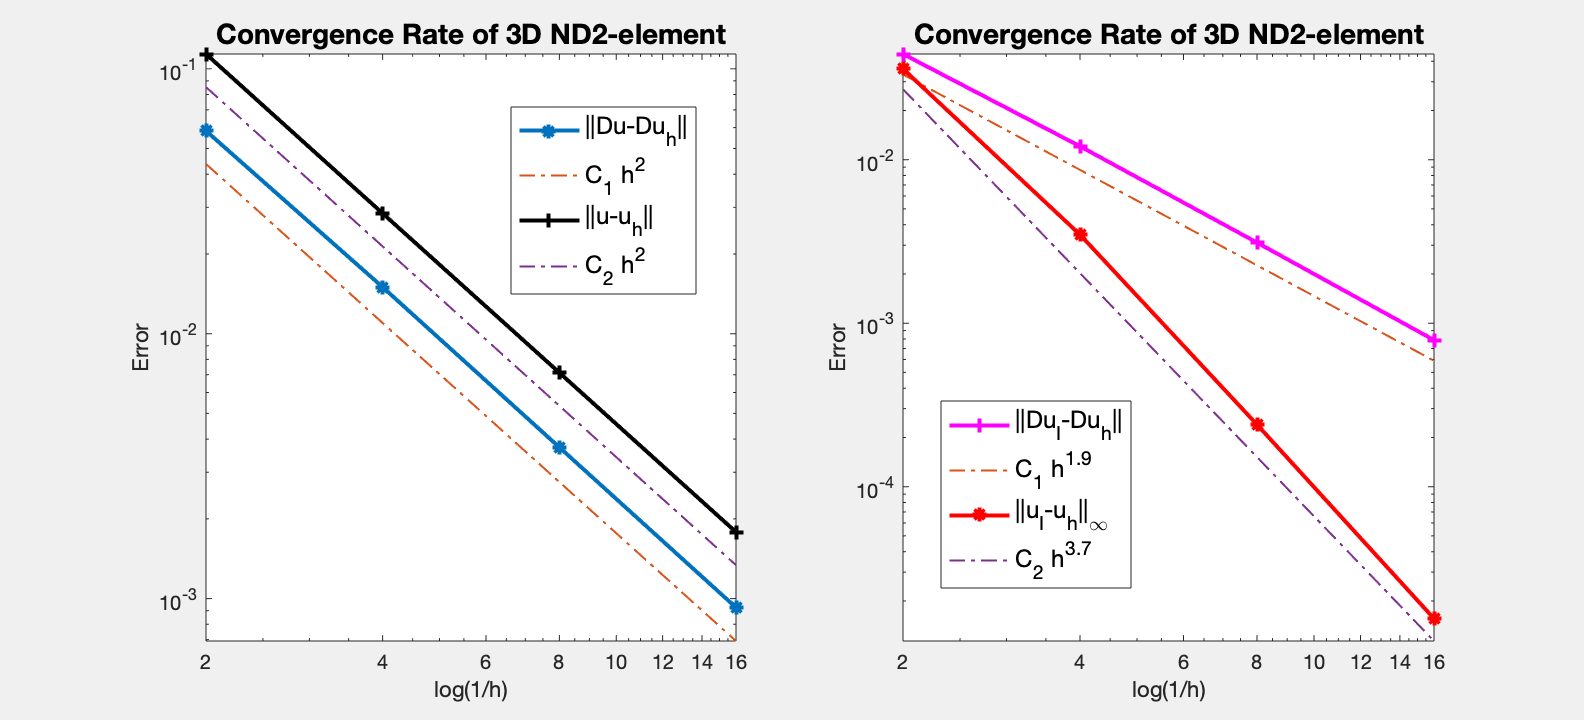

In [5]:
%% Setting
[node,elem] = cubemesh([-1,1,-1,1,-1,1],1);
mesh = struct('node',node,'elem',elem);
option.L0 = 0;
option.maxIt = 4;
option.elemType = 'ND2';
option.printlevel = 1;
option.plotflag = 1;
imatlab_export_fig('print-png')  % Static png figures.

%% Dirichlet boundary condition.
fprintf('Dirichlet boundary conditions. \n');    
pde = Maxwelldata2;
bdFlag = setboundary3(node,elem,'Dirichlet');
femMaxwell3(mesh,pde,option);

##  Neumann Boundary Condition

Neumann boundary condition. 
#dof:      436, Direct solver 0.07 
#dof:     2936, Direct solver 0.12 
Conjugate Gradient Method using HX preconditioner 
#dof:    21424,   #nnz:   812592,   iter: 48,   err = 9.8413e-09,   time = 0.81 s
Conjugate Gradient Method using HX preconditioner 
#dof:   163424,   #nnz:  6416872,   iter: 48,   err = 7.9588e-09,   time =  6.5 s
Table: Error
 #Dof        h        ||u-u_h||    ||Du-Du_h||   ||DuI-Du_h|| ||uI-u_h||_{max}

   436   5.000e-01   9.46920e-02   5.19223e-02   5.21912e-02   1.10980e-01
  2936   2.500e-01   2.60741e-02   1.41384e-02   1.33189e-02   1.37866e-02
 21424   1.250e-01   6.82809e-03   3.61596e-03   3.28025e-03   1.74118e-03
163424   6.250e-02   1.74533e-03   9.11412e-04   8.10177e-04   2.18397e-04

Table: CPU time
 #Dof    Assemble     Solve      Error      Mesh    

   436   6.00e-02   7.00e-02   2.00e-02   0.00e+00
  2936   9.00e-02   1.20e-01   4.00e-02   0.00e+00
 21424   4.60e-01   8.10e-01   2.70e-01   1.00e-02
163424   2.87e+0

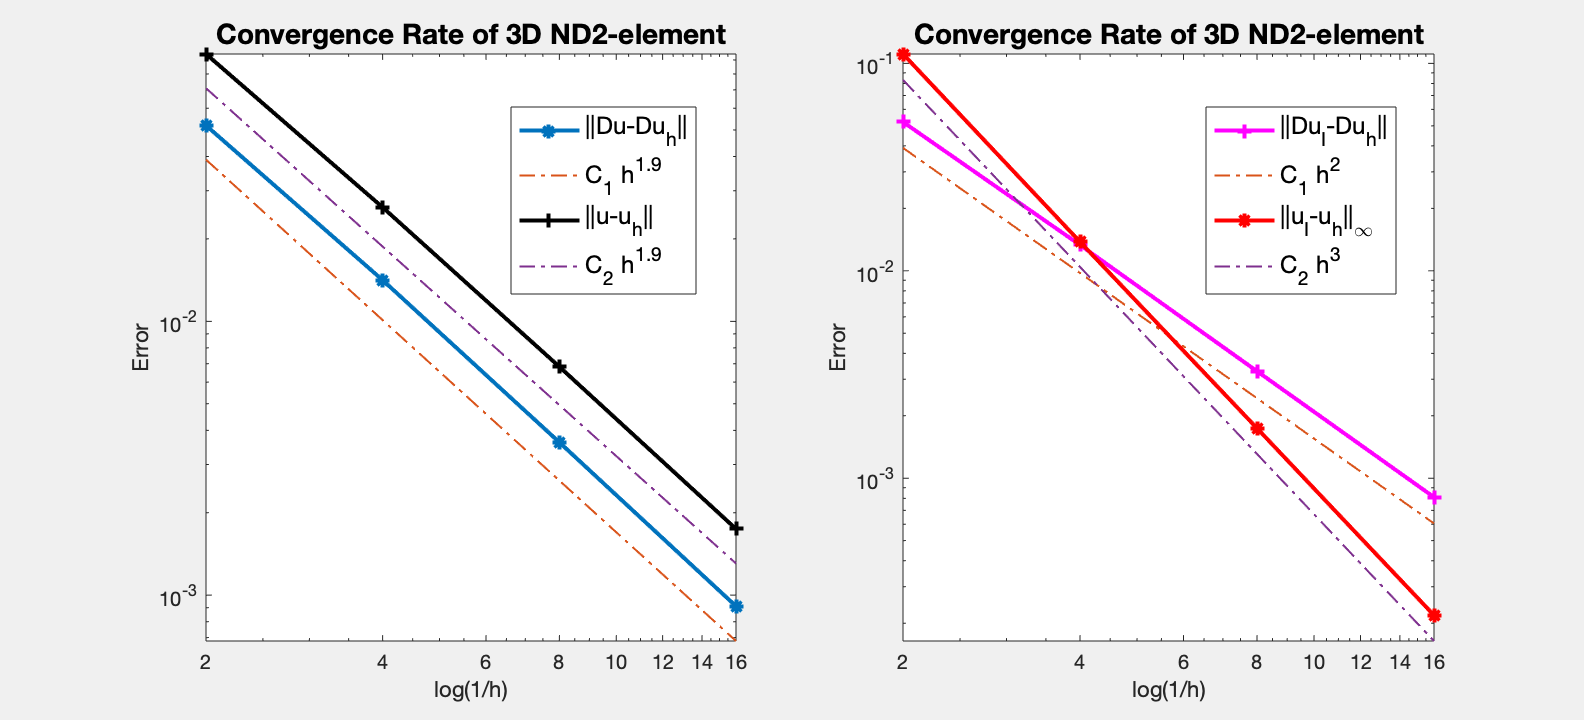

In [6]:
fprintf('Neumann boundary condition. \n');
option.plotflag = 0;
pde = Maxwelldata2;
mesh.bdFlag = setboundary3(node,elem,'Neumann');
femMaxwell3(mesh,pde,option);

## Conclusion 

Both the H(curl)-norm and the L2-norm is 2nd order. 

MGCG using HX preconditioner converges uniformly in all cases.